# Most Recent Image Processing

In [7]:
#imports
from PIL import Image, ImageDraw
#import image_slicer
import numpy as np
import cv2
import skimage
from scipy import ndimage as ndi
from skimage import feature, color,io
from skimage.morphology import square
import matplotlib.pyplot as plt
import math
from skimage.transform import probabilistic_hough_line

### Read in Image + Basic Filtering 


(-0.5, 751.5, 559.5, -0.5)

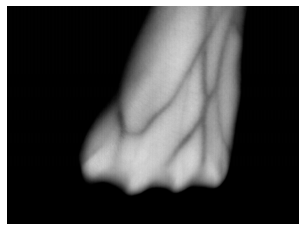

In [48]:
# run this or jojo's (next code block)

# Read Image
img = plt.imread('hand.png')
#img = plt.imread('jojo4_bottom.jpg')

# Show image
plt.imshow(img)
plt.axis('off')


### Adjustment for JoJo's image

<ipython-input-124-16efc8270e4d>:4: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  gray = color.rgb2gray(img)


(-0.5, 3279.5, 2463.5, -0.5)

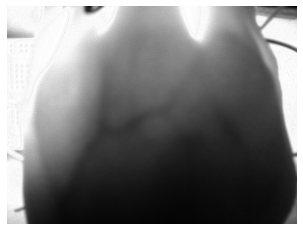

In [124]:
img = plt.imread('Joj3.jpg')
img=img[:,:,2] 
img = skimage.exposure.adjust_gamma(img, gamma=2.9, gain=.91)
gray = color.rgb2gray(img)

plt.imshow(img,cmap=plt.cm.gray)
plt.axis('off')

skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_yen


(<Figure size 576x360 with 8 Axes>,
 array([<AxesSubplot:title={'center':'Original'}>,
        <AxesSubplot:title={'center':'Isodata'}>,
        <AxesSubplot:title={'center':'Li'}>,
        <AxesSubplot:title={'center':'Mean'}>,
        <AxesSubplot:title={'center':'Minimum'}>,
        <AxesSubplot:title={'center':'Otsu'}>,
        <AxesSubplot:title={'center':'Triangle'}>,
        <AxesSubplot:title={'center':'Yen'}>], dtype=object))

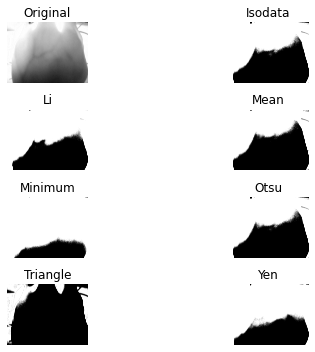

In [113]:
skimage.filters.try_all_threshold(img, figsize=(8, 5), verbose=True)

(-0.5, 3279.5, 2463.5, -0.5)

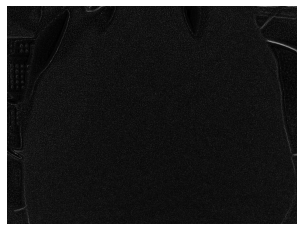

In [110]:

fil=skimage.filters.meijering(img,sigmas=range(0, 4, 1),black_ridges=True)
plt.imshow(fil,cmap=plt.cm.gray)
plt.axis('off')

(-0.5, 3279.5, 2463.5, -0.5)

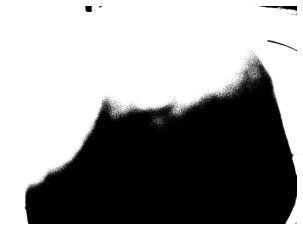

In [111]:
# Threshold and turn to binary
threshold = skimage.filters.threshold_otsu(gray)
binary = (gray >= threshold)

plt.imshow(binary,cmap=plt.cm.gray)
plt.axis('off')

In [101]:
threshold

164

### Normal analysis

(-0.5, 751.5, 559.5, -0.5)

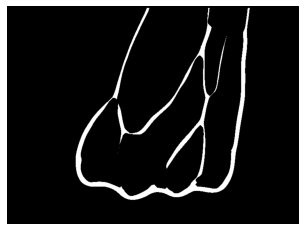

In [49]:
# Filter using meijering - normal 
img = skimage.filters.meijering(img,black_ridges=True)

# Turn to gray
gray = color.rgb2gray(img)

# Threshold and turn to binary
threshold = skimage.filters.threshold_otsu(gray)
binary = (gray >= threshold)

# Filter noise -erosion filter
out = ndi.morphology.binary_erosion(binary, iterations=5)

# Show image
plt.imshow(out, cmap=plt.cm.gray)
plt.axis('off')

### Create copy to filter out outer hand

(-0.5, 751.5, 559.5, -0.5)

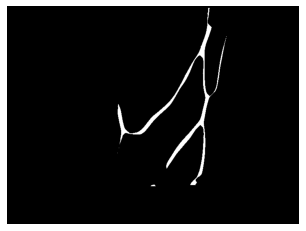

In [50]:
# Copy Image
out1=out

# Close gaps
closing=skimage.morphology.area_closing(binary,100000,connectivity=2)

# Find Edges
edges = feature.canny(closing,sigma=1)

# make edge bigger
img2=skimage.morphology.dilation(edges,square(40))

#Convert (from True+False to 1,0's)
img2=img2*1
out1=out1*1

# Combine masks
combined = cv2.bitwise_xor(img2, out1) 
combined = cv2.bitwise_and(combined, out1)

# Filter noise -erosion filter (don't need)
#filt = ndi.morphology.binary_erosion(combined, iterations=3)

# Show image - FIltered out outer hand
plt.imshow(combined, cmap=plt.cm.gray)
plt.axis('off')

### Get Skeleton Image (edges)

(-0.5, 751.5, 559.5, -0.5)

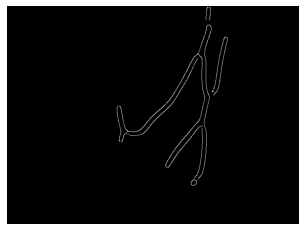

In [51]:
edges = feature.canny(combined, sigma = 5, low_threshold = 0.01, high_threshold = 0.2)

# Show Image
plt.imshow(edges, cmap=plt.cm.gray) # turn to gray
plt.axis('off')

### Transform to Hough Using edge image

(-0.5, 751.5, 559.5, -0.5)

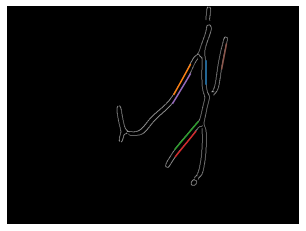

In [60]:
# Line finding using the Probabilistic Hough Transform
lines = probabilistic_hough_line(edges, threshold=60, line_length=60, line_gap=1)

# Show previous image (overlaying)
plt.imshow(edges, cmap=plt.cm.gray)

slope=[] # save slopes for later processing

# plot new lines
for line in lines:
    # Calculate Radius between parallel line to find thickest veins
        p0, p1 = line
        slope.append(abs(p0[0]-p1[0])/abs(p0[1]-p1[1])) # calculate slope of each line 
        plt.plot((p0[0], p1[0]), (p0[1], p1[1]))

# Add title 

#plt.title('Probabilistic Hough')
plt.axis('off')

### Fucntions Used to post-process further

**mid_line_dist:**
Finds the distance between 2 lines from thier midpoints

Takes in 2 lines defined by 2 points (see below bc its weird)

Outputs distance (linear)

e.g) line=( (x1,x2),(y1,y2) )

In [36]:
def mid_line_dist(line1,line2,slope1):
    
    
    # get point from lines
    pointa1,pointa2=line1
    pointb1,pointb2=line2
    
    
    # Get y-inter
    b_line1=pointa1[1]-slope1*pointa1[0] #b=y-mx
    b_line2=pointb1[1]-slope1*pointb1[0]
    
    # calc distance
    parallel_dist1= abs(b_line2-b_line1)/(np.sqrt((slope1**2)+1))

    # comment out - Testing/visualizing
    '''
    plt.plot(pointa1[0],pointa1[1],'r*')
    plt.plot(pointa2[0],pointa2[1],'r*')
    plt.plot(pointb1[0],pointb1[1],'c*')
    plt.plot(pointb2[0],pointb2[1],'c*')
    '''
    
    return parallel_dist1
    

[195.65097760032972, 188.09269307141133]

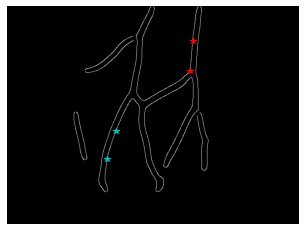

In [246]:
# SHow previous image
plt.imshow(edges, cmap=plt.cm.gray)
plt.axis('off')

mid_line_dist(lines[1],lines[8],slope[1],slope[8])

In [28]:
ind_parallel

[-1, -1, -1, -1, -1, -1]

**Plot_connect:**
Plots a line bewteen 2 lines at thier midpoint

Takes in 2 lines defined by 2 points (see below bc its weird)

No ouput, adds to figure that is already open

e.g) line=( (x1,x2),(y1,y2) )

In [14]:
def plot_connect(line1,line2):
    p0,p1=line1
    xa,xb=(p0[0]+p1[0])/2,(p0[1]+p1[1])/2
    p0,p1=line2
    ya,yb=(p0[0]+p1[0])/2,(p0[1]+p1[1])/2
    plt.plot((xa,ya),(xb,yb))
    return

**Get_mid:**
Gets mid point between 2 lines at their midpoint 

Takes in 2 lines defined by 2 points (see below bc its weird)

Outputs a single point

In [15]:
def get_mid(line1,line2):
    p0,p1=line1
    xa,xb=(p0[0]+p1[0])/2,(p0[1]+p1[1])/2
    p0,p1=line2
    ya,yb=(p0[0]+p1[0])/2,(p0[1]+p1[1])/2
    
    xf=(xa+ya)/2
    yf=(yb+xb)/2
    return (xf,yf)

### GO through all slopes and find ones that are similar 

In [53]:
# Find Parallel Lines that are ~close~

thresh =0.07 # error between slopes

# Create empty lists to stroe data 
thick=[-1]*len(lines)
ind_parallel=[-1]*len(lines)

# loop through all slopes and compare slope i to all other slopes
for i in range(len(slope)):
    
    # inner loop to compare to others
    for j in range(0,len(slope)):
        # j==i = itself
        if j==i:
            continue
            
       # compute pairs of slopes that are within threshold 
        if abs(slope[i]-slope[j])<thresh and mid_line_dist(lines[i],lines[j],slope[j])<50 and mid_line_dist(lines[i],lines[j],slope[j])>5 :
            ind_parallel[i]=j # provides index
            
            # get all thicknesses of good slopes - used later for thickest vein
            thick[i]=(mid_line_dist(lines[i],lines[j],slope[i]))
            
            break # we only want 1 slope 

In [371]:
# Filter pairs that don't match

for i in ind_parallel:
    if i ==-1:
        continue
    else:
        if ind_parallel.index(i)!=ind_parallel[i]:
            print(i,ind_parallel[i])
            ind_parallel[ind_parallel.index(i)]=-1

24 -1


In [25]:
ind_parallel

[-1, -1, -1, -1, -1, -1]

In [21]:
ind_parallel

[-1, -1, -1, -1, -1, -1]

### Show intermediate post-processing

- SOmething is wrong here 

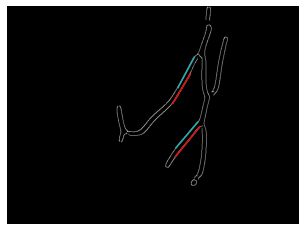

In [56]:
# SHow previous image
plt.imshow(edges, cmap=plt.cm.gray)
plt.axis('off')

# plot parallels and connectors
for i in range(len(lines)):
    if ind_parallel[i]==-1:
        continue
    else:
        
        line1=lines[i]
        line2=lines[ind_parallel[i]]
        
        pointa1,pointa2=line1
        pointb1,pointb2=line2
        
        plt.plot((pointa1[0],pointa2[0]),(pointa1[1],pointa2[1]),'r')
        #plt.plot(pointa2[0],pointa2[1],'r*')
        plt.plot((pointb1[0],pointb2[0]),(pointb1[1],pointb2[1]),'c')
        
        plt.plot()
        
        #plot_connect(line1,line2)
        

### Plot Best Access Point = Thickest vein form parallel lines

(-0.5, 751.5, 559.5, -0.5)

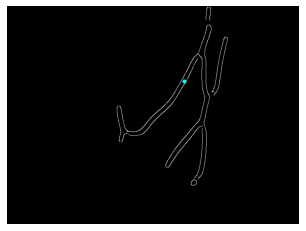

In [55]:
# Show previous image
plt.imshow(edges, cmap=plt.cm.gray)

# Get thickest vein by using max()
b_ind=thick.index(max(thick))
line1=lines[b_ind]
p0, p1 = line1


line2=lines[ind_parallel[b_ind]]
p0, p1 = line2
#plt.plot((p0[0], p1[0]), (p0[1], p1[1]))

pnt=get_mid(line1,line2)


plt.plot(pnt[0],pnt[1], marker='o', markersize=3, color="cyan")
plt.axis('off')

# Jojo Hand color channels

(-0.5, 3279.5, 2463.5, -0.5)

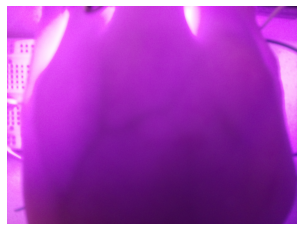

In [122]:
# Read Image
img = plt.imread('Joj3.jpg')

plt.imshow(img)
plt.axis('off')

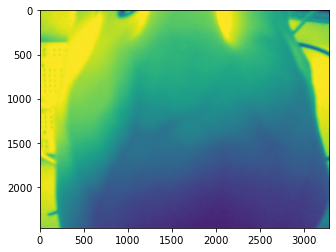

In [116]:
img = plt.imread('Joj3.jpg')
red=img[:,:,0] 
plt.imshow(red)

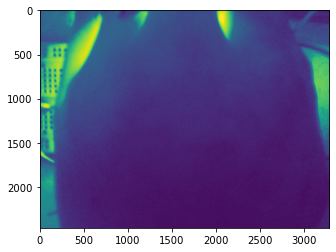

In [117]:
img = plt.imread('Joj3.jpg')
green=img[:,:,1] 
plt.imshow(green)

(-0.5, 3279.5, 2463.5, -0.5)

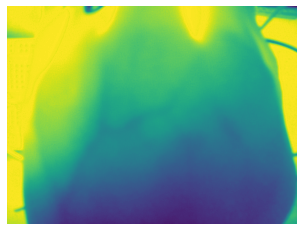

In [121]:
img = plt.imread('Joj3.jpg')
blue=img[:,:,2] 
plt.imshow(blue)
plt.axis('off')